# Importing

## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
import time
import random
import math
from multiprocessing import Process, Queue

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.models import load_model
from keras.optimizers import SGD, adam, nadam, adagrad, rmsprop, adadelta

Using TensorFlow backend.


## Importing own code

In [2]:
from generateSpace import *
from plotLattice import *
from getTriangleLengths import *
from potentialEnergyPerTrio import *
from potentialEnergy import *
from potentialEnergyPerParticle import *
from numberOfCalculations import *
from makeRandomDatabase import *
from prepareDatabaseForMachineLearning import*

## Writing own code

### Analysis code

In [3]:
def plotHistory(fitDetails):
    """
    hjhgj
    """
    history = {'loss': fitDetails.history['loss'], 'val_loss': fitDetails.history['val_loss']}
    
    maximumValue = max(max(history['loss']), max(history['val_loss']))
    minimumValue = min(min(history['loss']), min(history['val_loss'])) / 10#math.pow(math.floor(math.log(min(min(history['loss']), min(history['val_loss'])), 10)) - 1, 10)
    numberOfEpochs = len(history['loss'])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax1.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax1.legend()
    ax1.set_xlim(1, numberOfEpochs)
    ax1.set_ylim(0, maximumValue)
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss (training and validation) vs the number of epochs.')
    
    ax2.plot(history['loss'], history['val_loss'])
    ax2.set_xlim(0, maximumValue)
    ax2.set_ylim(0, maximumValue)
    ax2.set_xlabel('Training loss')
    ax2.set_ylabel('Validation loss')
    ax2.set_title('Validation loss vs training loss.')
    
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['loss'], label='Training loss')
    ax3.plot([i for i in range(1, numberOfEpochs + 1)], history['val_loss'], label='Validation loss')
    ax3.legend()
    ax3.set_xlim(1, numberOfEpochs)
    ax3.set_yscale('log')
    ax3.set_ylim(minimumValue, maximumValue)
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Loss')
    ax3.set_title('Loss (training and validation) vs the number of epochs (logarithmic)')
    
    ax4.plot(history['loss'], history['val_loss'])
    ax4.set_xscale('log')
    ax4.set_xlim(minimumValue, maximumValue)
    ax4.set_yscale('log')
    ax4.set_ylim(minimumValue, maximumValue)
    ax4.set_xlabel('Training loss')
    ax4.set_ylabel('Validation loss')
    ax4.set_title('Validation loss vs training loss (logarithmic).')
    
    plt.show()
    history['figure'] = [fig, ax1, ax2, ax3, ax4]
    
    return history

In [4]:
def makePredictionPlot(model, dataFrame, amountOfPoints=1000):
    prediction = []
    realValue = []
    
    for i in range(min(len(dataFrame['potentialEnergy']), amountOfPoints)):
        index = dataFrame.index[i]
        prediction.append(model.predict([[dataFrame['eigenvalues'][index]]])[0][0])
        realValue.append(dataFrame['potentialEnergy'][index])
    
    fig, ((ax1)) = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
    ax1.scatter(realValue, prediction, s=5)
    ax1.set_xlim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_ylim(min(min(prediction), min(realValue)), max(max(prediction), max(realValue)))
    ax1.set_xlabel('Real energy')
    ax1.set_ylabel('Predicted energy')
    ax1.set_title('Predicted energy vs real energy.')
    
    plt.show()

In [5]:
def plotAndPredict(model, dataFrame, indexNumber):
    prediction = model.predict([[dataFrame['eigenvalues'][indexNumber]]])[0][0]
    realValue = dataFrame['potentialEnergy'][indexNumber]
    
    fig, ax = plotLatticeFromDataFrame(dataFrame, indexNumber)
    print('For index', indexNumber, 'Predicted', prediction, 'was', realValue)
    return fig, ax

### Network code

In [6]:
def makeDenseNetwork(inputSize, settings, learningRate, kernalInitializer='he_uniform', lossFunction='MAE', optimizer=adam):#https://keras.io/api/losses/regression_losses/
    """
    jhgjhgj
    """
    model = Sequential()
    model.add(Dense(settings[0][1], input_dim=inputSize, use_bias=settings[0][3], activation=settings[0][2], kernel_initializer=kernalInitializer))
    #model.add(Activation(settings[0][2]))
    
    for i in range(1, len(settings)):
        setting = settings[i]#0 is kind of layer, rest are settings.
        
        model.add(Dense(setting[1], use_bias=setting[3], activation=setting[2], kernel_initializer=kernalInitializer))
        #model.add(Activation(setting[2]))
    
    opt = optimizer(lr=learningRate)
    model.compile(loss=lossFunction, optimizer=opt)
    
    return model

In [7]:
def makeLinearNet(learningRate, inputDim, loss):
    model = Sequential()
    opt = adam(lr=learningRate)
    model.add(Dense(1, activation="linear", use_bias=False, input_dim=inputDim))
    model.compile(loss=loss, optimizer=opt)
    return model

# Getting data

## Importing data and settings

In [8]:
filename = 'databaseModLen_min_cut0.90_widths86_Width1.5-10_3-1sur_epoch30_maxDelta0.1_R20_M2M3Prepared'#'OLDcombinedDataR100M2M3M4Prepared'#'combinedDataPrepared'
orderOfMatrix = [-2, -3]# Make a list if you want to do the calculations yourself and make a other type of you want to import it
inputSize=13#4 * len(orderOfMatrix)

data = pd.read_json(filename + '.json', orient='columns')
data['particleCoordinates'] = data['particleCoordinates'].apply(np.array)
data['eigenvalues'] = data['eigenvalues'].apply(np.array)
#data['eigenvalues'] = data['eigenvalues'].apply(np.transpose)
#data['eigenvalues'] = data['eigenvalues'].apply(list)

offset = 0#min(data['potentialEnergy'])
print('Offset is', offset)
data['potentialEnergy'] = data['potentialEnergy']-offset

Offset is 0


## Inspecting data

In [9]:
data.head()

,index,particleCoordinates,widthOfCell,numberOfSurroundingCells,potentialEnergy,eigenvalues,relativeDistances
0,16240,"[[0.7568887144, 1.7685255752], [0.1297189098, ...",2.7,3,-4.596381,"[-155595.5084728395, -389.9529814805, 1521.543...","[2.7, 0.0025707372, 1.1757235893, 2.1846271742..."
1,16241,"[[2.0425056622, 1.6989714468], [1.7219134703, ...",2.7,3,-5.948705,"[-1575.735781932, -559.2010946783, 236.8185235...","[2.7, 0.2563910411, 0.7630489258, 1.033243676,..."
2,16242,"[[0.42269750370000003, 1.2410828812], [0.57424...",2.7,3,-5.668112,"[-1272.435954481, -521.0483505899, 81.23277798...","[2.7, 0.3193683265, 0.831091113, 0.94550295130..."
3,16243,"[[2.3830583804, 1.2074391325], [1.3053535702, ...",2.7,3,-6.165852,"[-966.3911551727, -870.5288375645, 179.6479959...","[2.7, 0.4322595195, 0.4568524632, 1.1875173367..."
4,16244,"[[2.3516804941, 2.029534644], [1.5857188892, 1...",2.7,3,-3.658218,"[-1355.3405989462, -680.3052051724, 32.7884982...","[2.7, 0.5128421674, 0.6014235434, 0.7871234139..."


In [10]:
data.describe()

,index,widthOfCell,numberOfSurroundingCells,potentialEnergy
count,64950.000000,64950.000000,64950.0,64950.000000
mean,32474.500000,4.714582,3.0,4.847734
std,18749.594329,2.078584,0.0,66.299529
min,0.000000,1.500000,3.0,-45.142848
25%,16237.250000,3.000000,3.0,-4.341829
50%,32474.500000,4.500000,3.0,-1.726104
75%,48711.750000,6.100000,3.0,-0.651513
max,64949.000000,10.000000,3.0,2665.287506


In [11]:

"""
qLow = data['potentialEnergy'].quantile(0.01)
qHi  = data['potentialEnergy'].quantile(0.99)
dataFiltered = data.copy()
#dataFiltered = data[(data['potentialEnergy'] < qHi) & (data['potentialEnergy'] > qLow)]

x = dataFiltered['potentialEnergy']
fig, ax = plt.subplots(figsize=(8, 8))
sortedX = np.sort(x) - 1.01 * min(x)
ax.plot([100*i/len(x) for i in range(0, len(x))], sortedX)
ax.set_xlim(0, 100)
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each percentile.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Percentile')
plt.show()

#"""


"""
tempData = dataFiltered.copy()
tempOfsett = 1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['5%', '50%', '95%'])
ax.set_yscale('log')
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""

"""
tempData = dataFiltered.copy()
tempOfsett = 0#1.01 * min(tempData['potentialEnergy'])
tempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett
medianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(medianData.index, medianData['potentialEnergy']['min'])
ax.plot(medianData.index, medianData['potentialEnergy']['5%'])
ax.plot(medianData.index, medianData['potentialEnergy']['50%'])
ax.plot(medianData.index, medianData['potentialEnergy']['95%'])
plt.legend(['min', '5%', '50%', '95%'])
plt.ylim(-30, 30)
ax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')
ax.set_ylabel('Energy per particle')
ax.set_xlabel('Width of cell')
plt.show()
#"""


"\ntempData = dataFiltered.copy()\ntempOfsett = 0#1.01 * min(tempData['potentialEnergy'])\ntempData['potentialEnergy'] = tempData['potentialEnergy'] - tempOfsett\nmedianData = tempData.groupby('widthOfCell').describe(percentiles=[0.05, 0.5, 0.95])\nfig, ax = plt.subplots(figsize=(8, 8))\nax.plot(medianData.index, medianData['potentialEnergy']['min'])\nax.plot(medianData.index, medianData['potentialEnergy']['5%'])\nax.plot(medianData.index, medianData['potentialEnergy']['50%'])\nax.plot(medianData.index, medianData['potentialEnergy']['95%'])\nplt.legend(['min', '5%', '50%', '95%'])\nplt.ylim(-30, 30)\nax.set_title('Plot of the energy per particle for each width of cell with offset of ' + str(tempOfsett) + '.')\nax.set_ylabel('Energy per particle')\nax.set_xlabel('Width of cell')\nplt.show()\n#"

## Preparing data

In [12]:

"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    inputData.append(trainingData['eigenvalues'][i])#TODO remove sorted once fixed in data
    #targetData.append(trainingData['potentialEnergy'][i])
    targetData.append(sum(trainingData['eigenvalues'][i]))

trainingInput = [[inputData], [targetData]]

inputData = []
targetData = []
for i in validationData.index:
    inputData.append(validationData['eigenvalues'][i])#TODO remove sorted once fixed in data
    targetData.append(validationData['potentialEnergy'][i])

validationInput = [[inputData], [targetData]]
"""
#"""
trainingData = data.sample(frac=0.8)
validationData = data.drop(trainingData.index)

inputData = []
targetData = []
for i in trainingData.index:
    #inputData.append(np.array(trainingData['eigenvalues'][i]))
    inputData.append(np.array(trainingData['relativeDistances'][i]))
    #targetData.append(trainingData['potentialEnergy'][i])
    #targetData.append(sum(trainingData['eigenvalues'][i]))
    targetData.append(sum(trainingData['relativeDistances'][i]))

trainingInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results training input:')
[print(trainingInput['input'][i], trainingInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(trainingInput['input']))
print(type(trainingInput['input']))
print(type(trainingInput['input'][0]))
print(np.shape(trainingInput['target']))
print(type(trainingInput['target']))

inputData = []
targetData = []
for i in validationData.index:
    #inputData.append(np.array(validationData['eigenvalues'][i]))
    inputData.append(np.array(validationData['relativeDistances'][i]))
    #targetData.append(validationData['potentialEnergy'][i])
    #targetData.append([sum(validationData['eigenvalues'][i])])
    targetData.append([sum(validationData['relativeDistances'][i])])

validationInput = {'input':np.array(inputData), 'target':np.array(targetData)}

print('Results validation input:')
[print(validationInput['input'][i], validationInput['target'][i], '\n') for i in range(0, 3)]
print(np.shape(validationInput['input']))
print(type(validationInput['input']))
print(type(validationInput['input'][0]))
print(np.shape(validationInput['target']))
print(type(validationInput['target']))

validationPlots = [random.choice(validationData.index) for i in range(0, 11)]

#"""
print()

Results training input:
[1.6        0.59105994 0.69302761 0.7775424  1.03309066 1.15628813
 2.14734471 0.45440938 0.57693357 0.68562417 1.05004437 1.24336632
 3.1466805 ] 15.1554117588 

[ 2.8         0.26382321  1.67661628  2.86416919  5.0052774   6.91516281
  9.81933002  0.13550943  2.17095349  4.84727885 11.19804548 18.1845942
 30.76966618] 96.65042654839999 

[  8.2          1.24893726  11.2186859   43.56447562  46.79719515
  50.47534527  60.99306543   1.39576059  37.57621079 287.54030976
 320.13247756 358.60715261 476.34399151] 1704.0936074441001 

(51960, 13)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(51960,)
<class 'numpy.ndarray'>
Results validation input:
[2.70000000e+00 2.57073720e-03 1.17572359e+00 2.18462717e+00
 2.24810671e+00 6.54830945e+00 6.66667224e+00 1.30342600e-04
 1.27484636e+00 3.22898477e+00 3.37074098e+00 1.67569044e+01
 1.72132809e+01] [63.37089765] 

[ 2.7         0.13553743  1.33605158  2.27970221  2.37086254  5.3783421
  6.51344192  0.04989866  1.54431

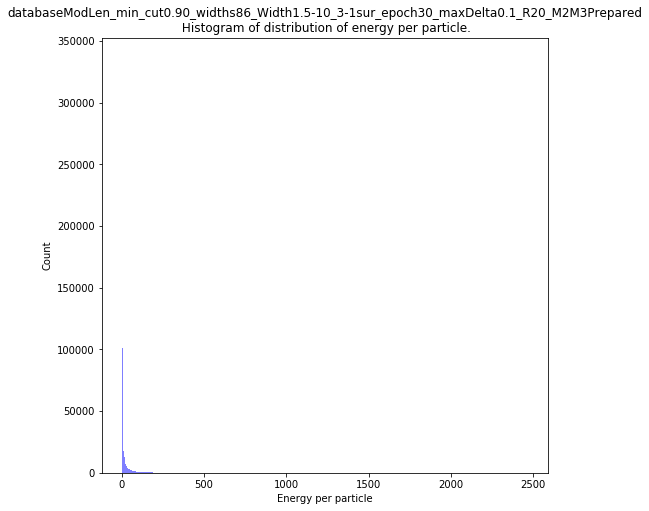

59.05967898582787
Mean 18.599190616711333 STD: None
707.3969403606404
[2466.3866155396, 2177.3709585242, 2062.2108467001, 2059.4619577156]


In [13]:
allEigenvalues =[]
[[allEigenvalues.append(abs(j)) for j in trainingInput['input'][i]] for i in range(len(trainingInput['input']))]

allEigenvalues = np.array(allEigenvalues)

fig, ax = plt.subplots(figsize=(8, 8))
n, bins, patches = ax.hist(allEigenvalues, 1000, facecolor='blue', alpha=0.5)
ax.set_title(filename + '\n Histogram of distribution of energy per particle.')
ax.set_xlabel('Energy per particle')
ax.set_ylabel('Count')
plt.show()

print('Mean', np.mean(allEigenvalues), 'STD:', print(np.std(allEigenvalues)))
print(np.percentile(allEigenvalues, 99.9))
print([np.sort(allEigenvalues)[-i] for i in range(1, 5)])

## Preparing test data

In [14]:
"""
widthOfCell = 5.0
numberOfSurroundingCells = 3
R0 = 20
x = np.linspace(0.1, 1.1, 60)

testData = {'particleCoordinates': [],'widthOfCell':[] , 'numberOfSurroundingCells': [], 'potentialEnergy':[]}# Initialy use a dictionary because it's easier to append to than a dataframe.
for i in x:
    particles = [np.array([0.1, 0.1]), np.array([0.55, 0.9]), np.array([0.6, 0.665]), np.array([0.5, i])]
    particles = [widthOfCell * coordinate for coordinate in particles]
    otherSpace = generateSpace(particles, numberOfSurroundingCells, widthOfCell)# Generate the other space.
    testData['particleCoordinates'].append(particles)
    testData['widthOfCell'].append(widthOfCell)
    testData['numberOfSurroundingCells'].append(numberOfSurroundingCells)
    testData['potentialEnergy'].append(potentialEnergy(otherSpace, particles, potentialEnergyPerTrio) - offset)# Calculate the potential energy and save it to the data dictonairy.

x = widthOfCell * x
testData = prepareDatabseForMachineLearning(pd.DataFrame(testData), orderOfMatrix, R0, giveUpdates = False)

fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), [testData['eigenvalues'][i] for i in range(len(testData['eigenvalues']))])
ax1.legend()
ax1.set_ylim(-1000, 1000)
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Eigenvalues')
ax1.set_title('Eigenvalues for different positions.')
plt.show()

testData.head()
testData.describe()

y = []
for i in range(len(x)):
    y.append(testData['potentialEnergy'][i])


fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(list(x), y, label='Real potential energy')
ax1.legend()
ax1.set_xlabel('Position of atom')
ax1.set_ylabel('Potential energy')
ax1.set_title('Predicted potential energy and real potential energy for different positions.')
#ax1.set_ylim(-0.75 * offset , 1.5 * max(y[1]))
plt.show()
#"""
print()

# Machine learning

In [15]:
models = []
prefixName = 0
saveFolder = 'testRun'
lossMetric = 'MAE'#keras.losses.MeanAbsoluteError()#keras.losses.MeanSquaredError()
#trainNetwork(model, trainingInput, 0.3, numberOfEpochs=100, batchSize=32, verboseSetting=1)
#fitDetails = network.fit(trainingData[0], trainingData[1], shuffle=True, batch_size=batchSize, validation_split=validationSplit, epochs=numberOfEpochs, verbose=max(0,verboseSetting))

def RSMPE(target,value):
    return ((keras.backend.mean(((value-target)/target)**2))**0.5)*100

def MAE(target,value):
    return keras.backend.mean(abs(value-target))


## Try linear network

In [27]:
def makeRandomNumberDatabaseSum(amountOfData, amountOfInputs=8, sigma=10**5):
    X = []
    y = []
    for i in range(amountOfData):#data.index:
        randomNumbers = [random.gauss(0, sigma) for j in range(0,amountOfInputs)]#[random.uniform(-maximalNumbers, maximalNumbers) for j in range(0,amountOfInputs)]

        X.append(randomNumbers)
        y.append(sum(randomNumbers))

    X = np.array(X)
    Y = np.array(y)

    return X, Y

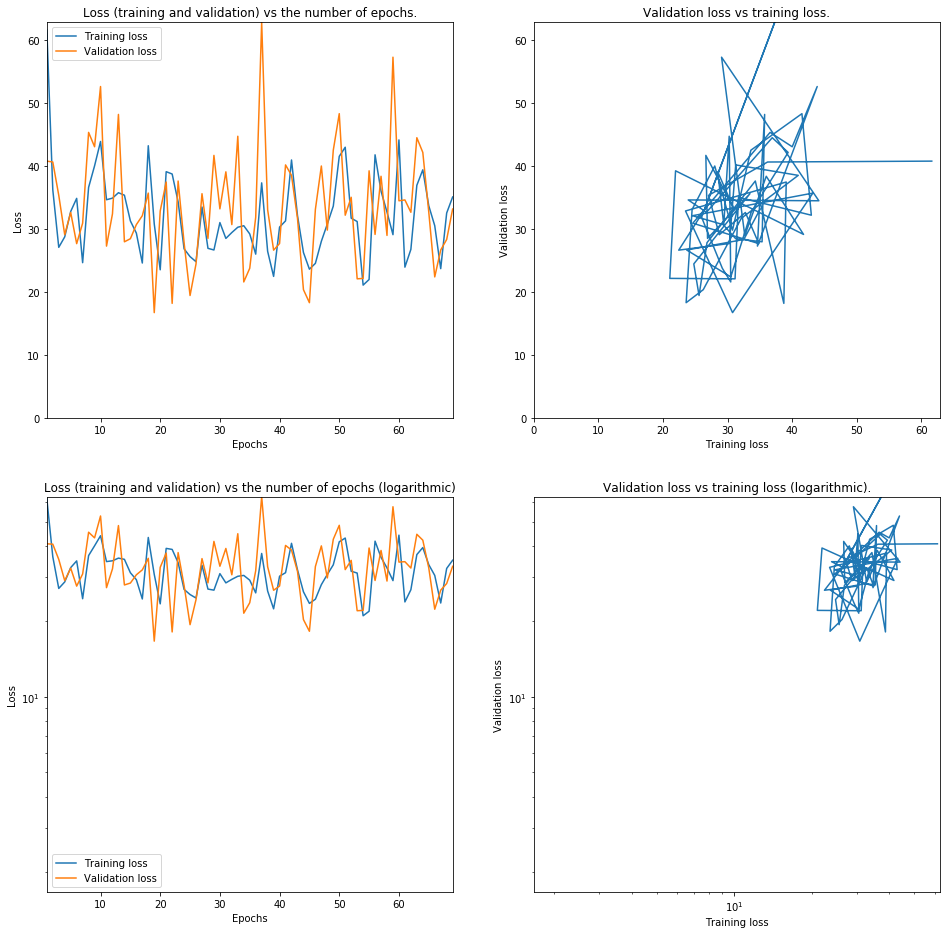

Amount of data 1000 Learning rate: 1.0 Amount of epochs: 40 Final loss: 31.25133968882658


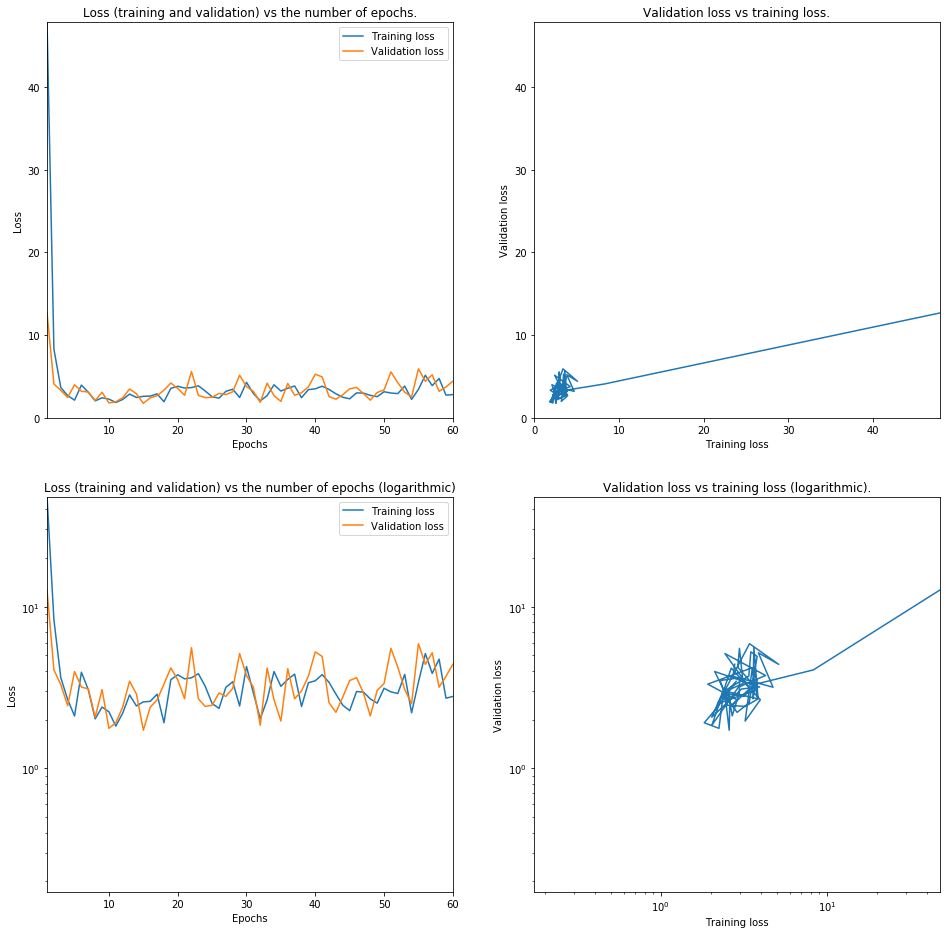

Amount of data 1000 Learning rate: 0.1 Amount of epochs: 8 Final loss: 3.1140076755017656


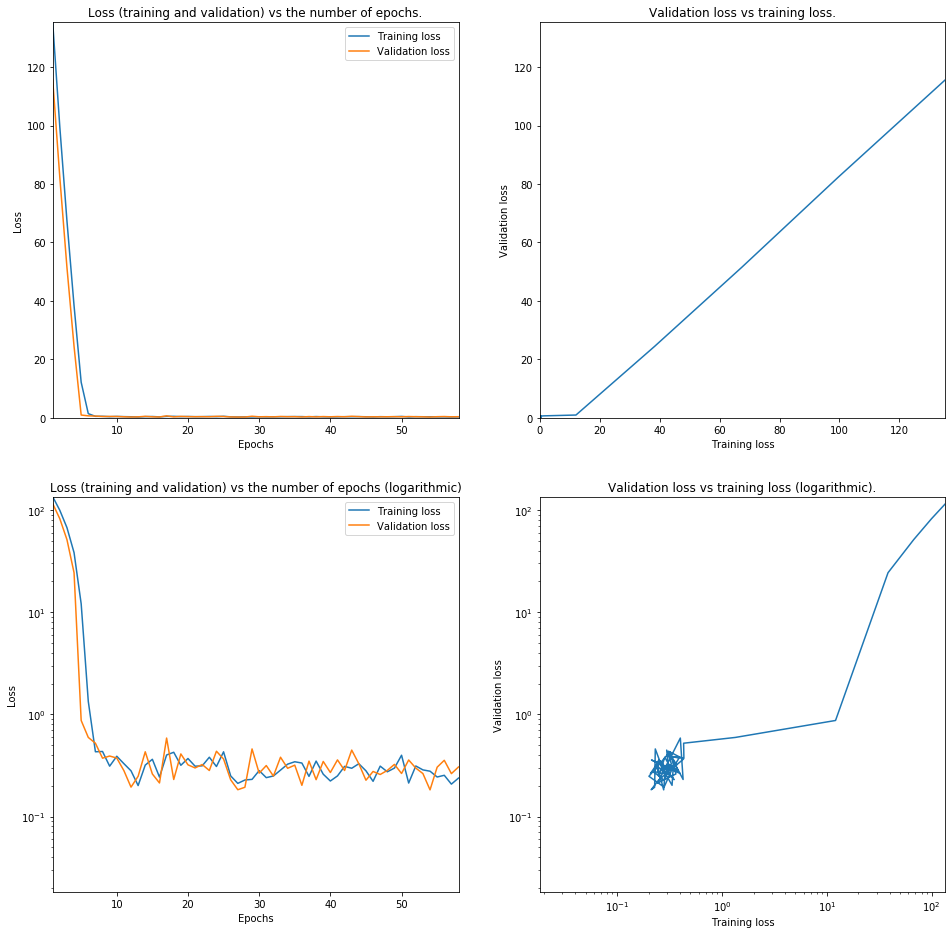

Amount of data 1000 Learning rate: 0.01 Amount of epochs: 10 Final loss: 0.294676295412641


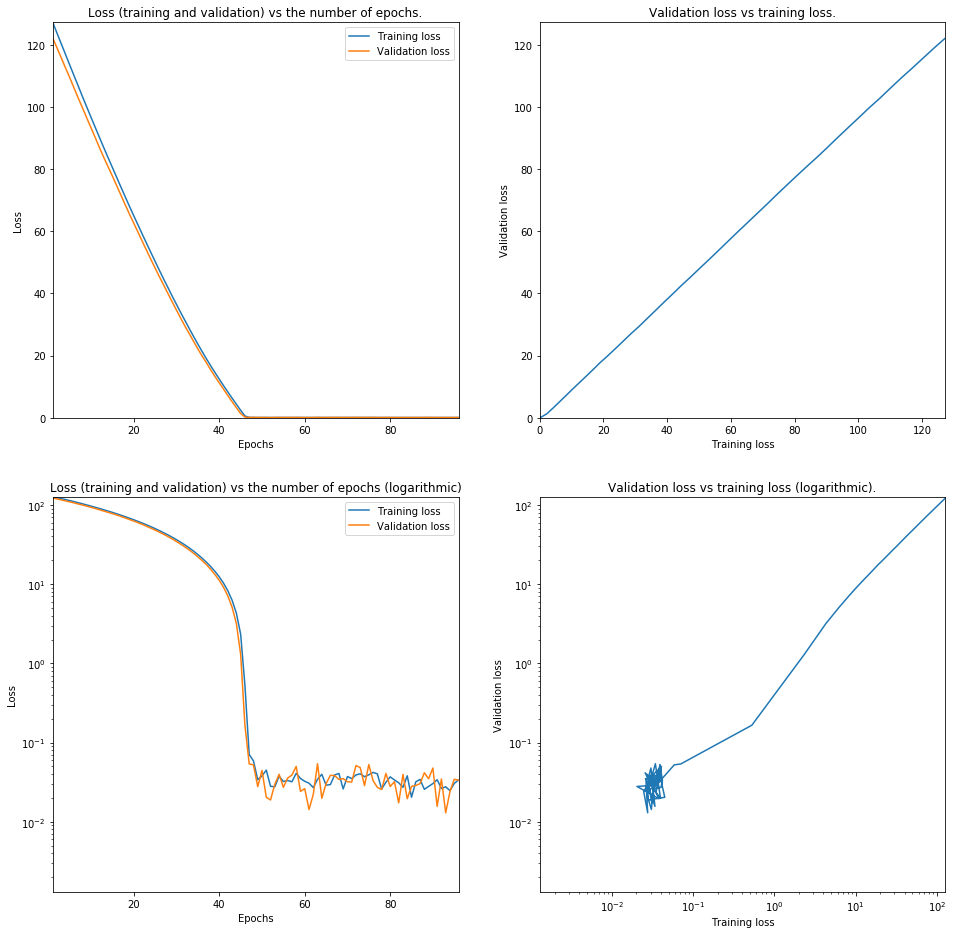

Amount of data 1000 Learning rate: 0.001 Amount of epochs: 55 Final loss: 0.03210837426041665


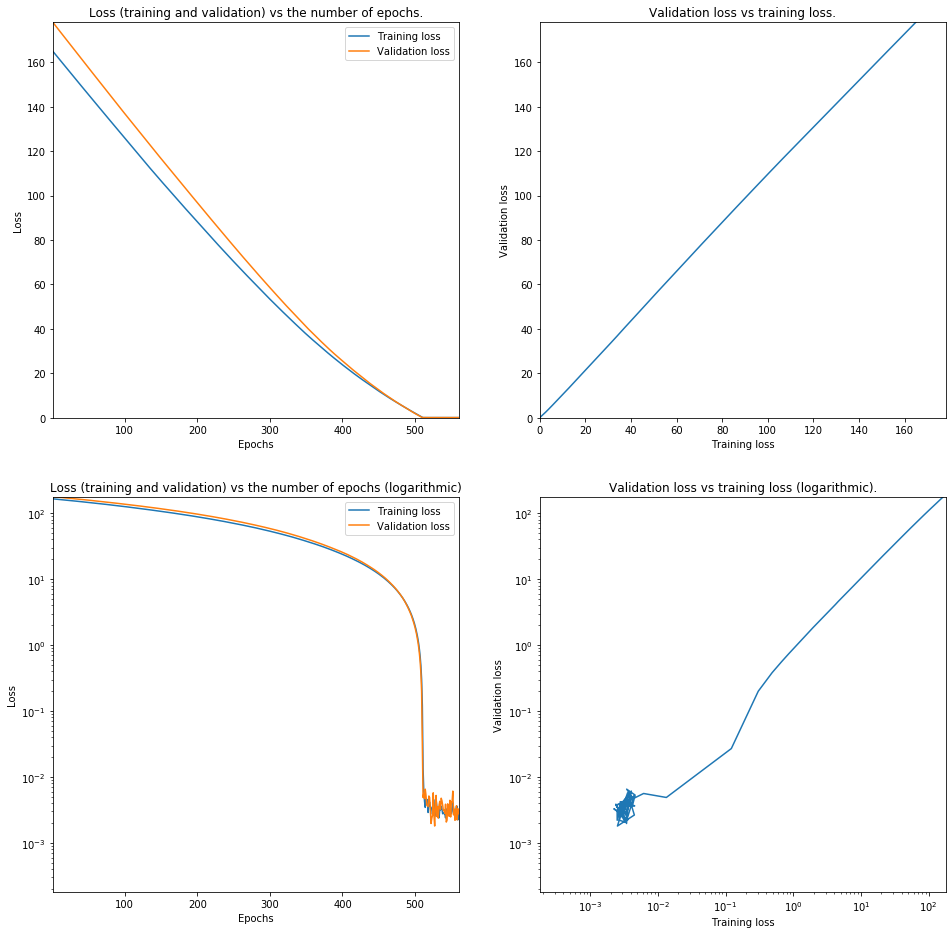

Amount of data 1000 Learning rate: 0.0001 Amount of epochs: 500 Final loss: 0.003495443096599814


KeyboardInterrupt: 

In [28]:
name = 'LinearNetwork'
settingsLineaerNet = [['Dense', 1, 'linear', False]]

maxEpochs = 10000

learningRate = []
amountOfData = []

repeat = 3
resulutionOfData = 3
resulutionOfLearning = 6

results = {'amountOfEpochs':[], 'finalLoss':[]}
for i in np.logspace(3, 5, resulutionOfData):
    i = math.ceil(i)
    amountOfData.append(i)
    
    resultsEpochs = []
    resultsLoss = []
    
    learningRateTemp = []
    
    for j in np.logspace(0, -5, resulutionOfLearning):
        learningRateTemp.append(j)
        
        resultsLossTemp = []
        resultsEpochsTemp = []
        
        
        for re in range(repeat):
            dataPointsX, dataPointsY = makeRandomNumberDatabaseSum(math.ceil(i/0.9), 8, 10*7)
            model = makeDenseNetwork(8, settingsLineaerNet, j, kernalInitializer='he_uniform', lossFunction=MAE)
            earlyStop = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)
            fitDetails = model.fit(dataPointsX, dataPointsY, epochs=maxEpochs, validation_split=0.1, verbose=0, callbacks=[earlyStop])
            loss = fitDetails.history['loss']
            resultsEpochsTemp.append(len(fitDetails.history['loss'])-50)
            resultsLossTemp.append(np.mean([loss[-k] for k in range(1, 50)]))
            
            
        history = plotHistory(fitDetails)
        resultsEpochs.append(math.ceil(np.mean(resultsEpochsTemp)))
        resultsLoss.append(np.mean(resultsLossTemp))
        
        print('Amount of data', math.ceil(i), 'Learning rate:', j, 'Amount of epochs:', resultsEpochs[-1], 'Final loss:', resultsLoss[-1])
    
    results['amountOfEpochs'].append(resultsEpochs)
    results['finalLoss'].append(resultsLoss)
    learningRate.append(learningRateTemp)



In [ ]:
for i in range(0, len(amountOfData)):
    print('Dataset of size', amountOfData[i])
    print(learningRate[i])
    print(results['amountOfEpochs'][i])
    print(results['finalLoss'][i])
    fig, ax1 = plt.subplots(figsize=(8, 8))
    color = 'tab:red'
    ax1.set_xlabel('Learning rate')
    ax1.set_xscale('log')
    ax1.set_xlim(10**0, 10**-6)
    ax1.set_ylabel('Amount of epochs', color=color)
    ax1.plot(learningRate[i], results['amountOfEpochs'][i], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('Final loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(learningRate[i], results['finalLoss'][i], color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

## Testing optimizers on real data

Optimizer: 0 learning rate: 0.0001


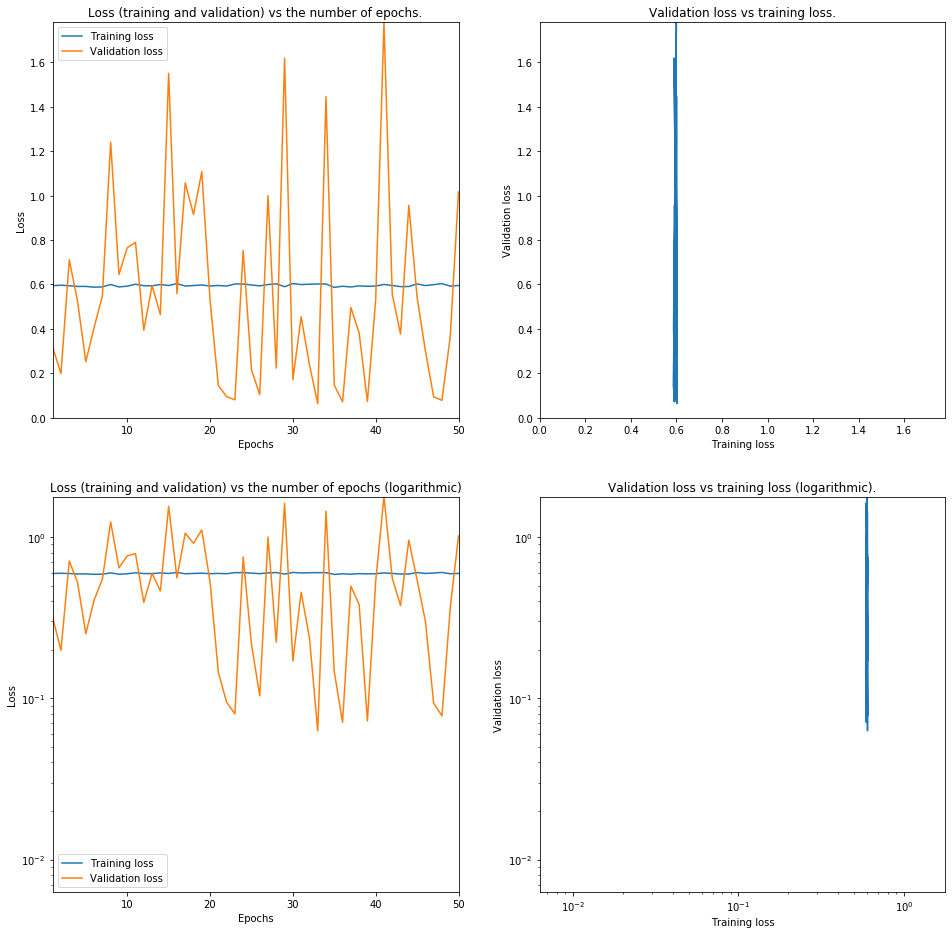

Optimizer: 0 learning rate: 3.1622776601683795e-05


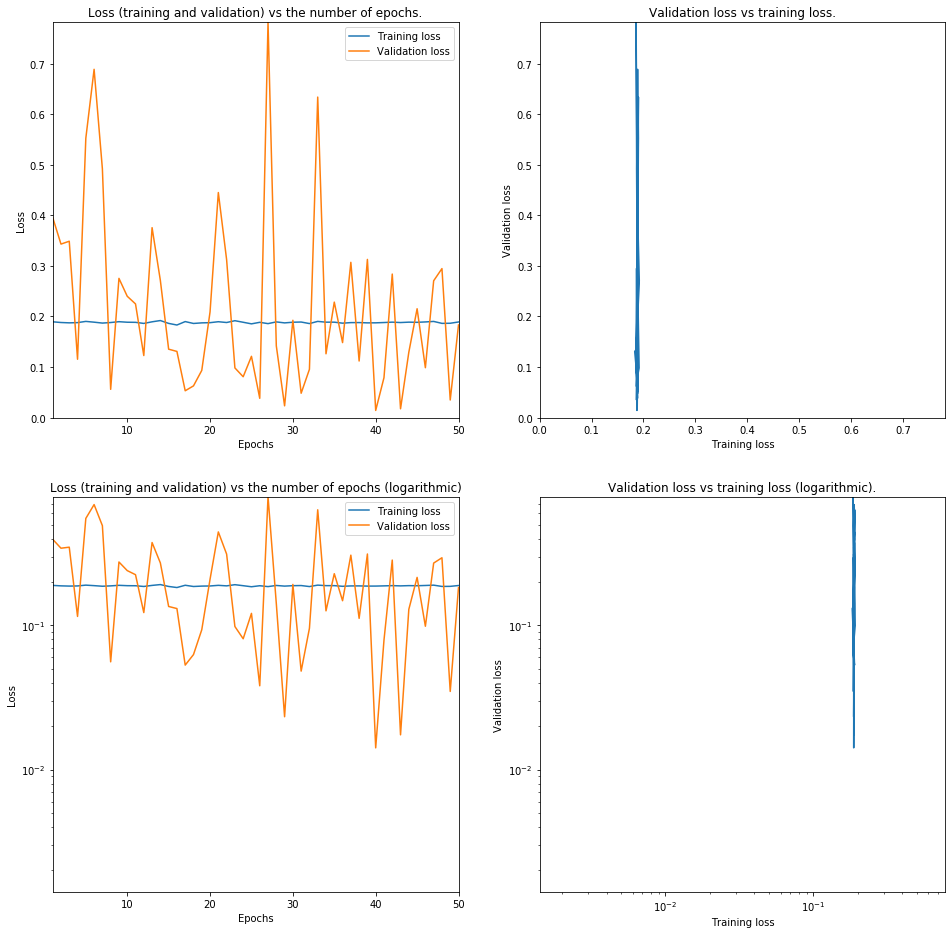

Optimizer: 0 learning rate: 1e-05


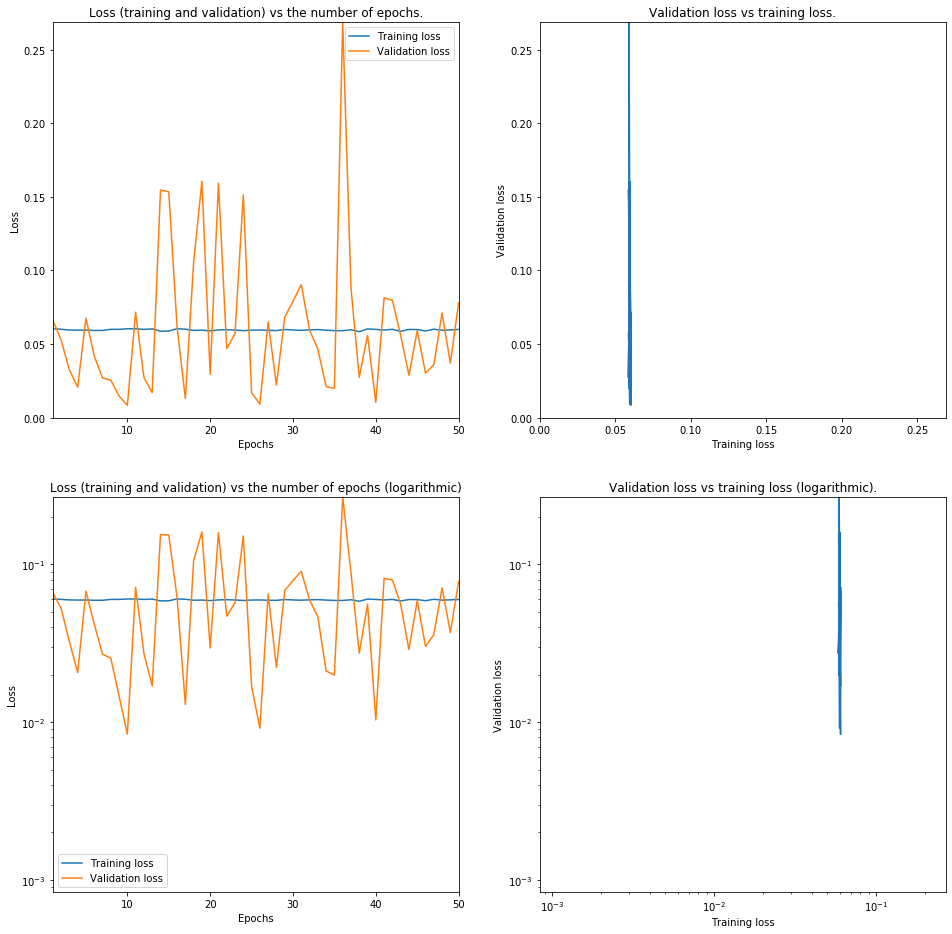

Optimizer: 0 learning rate: 3.162277660168379e-06


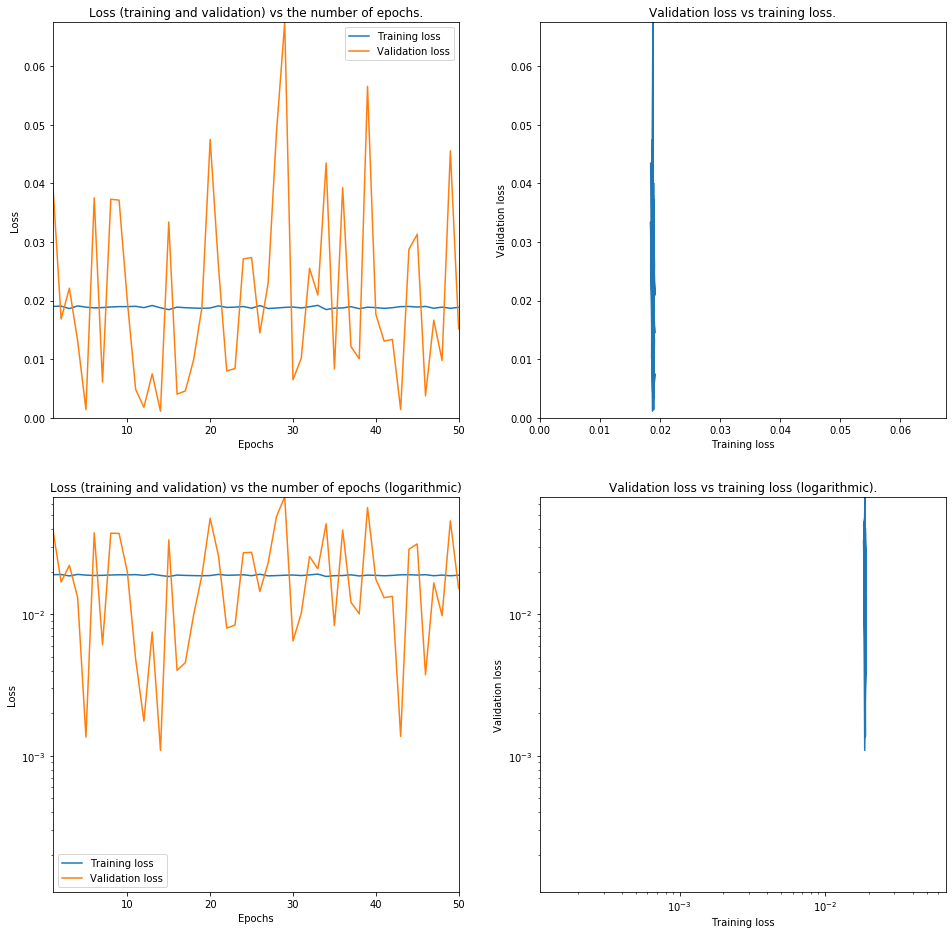

Optimizer: 0 learning rate: 1e-06


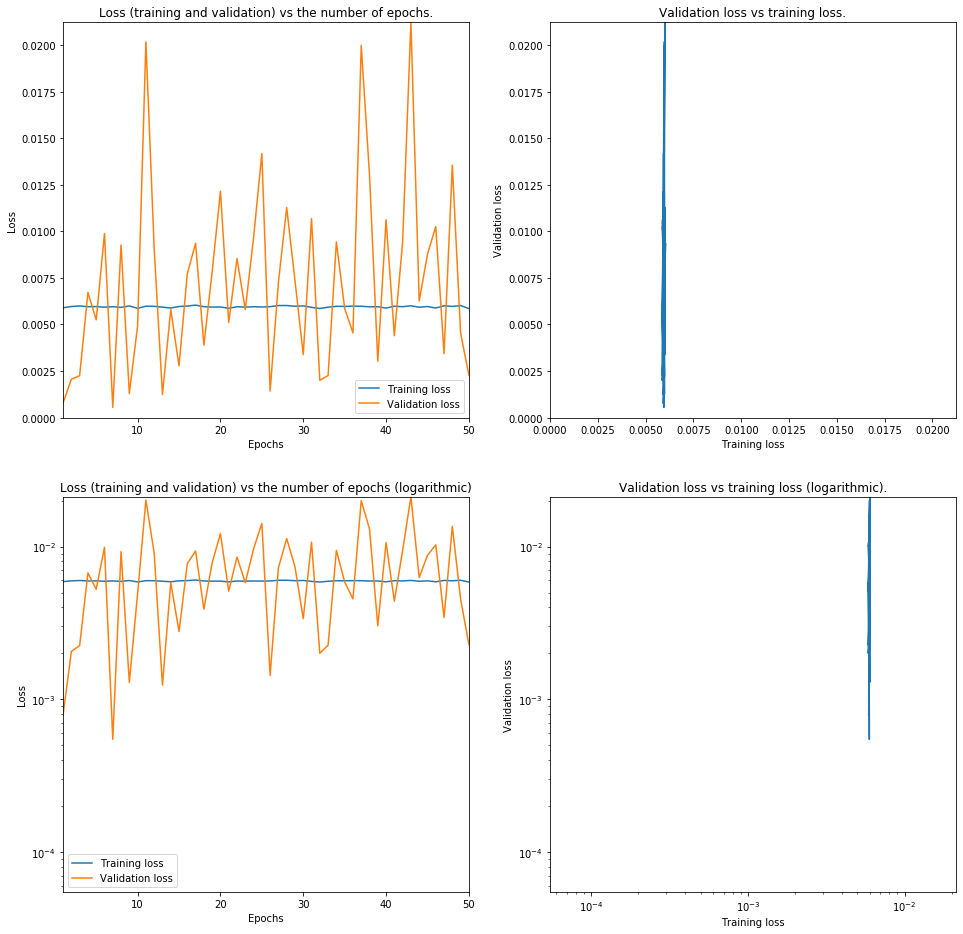

Optimizer: 0 learning rate: 3.162277660168379e-07


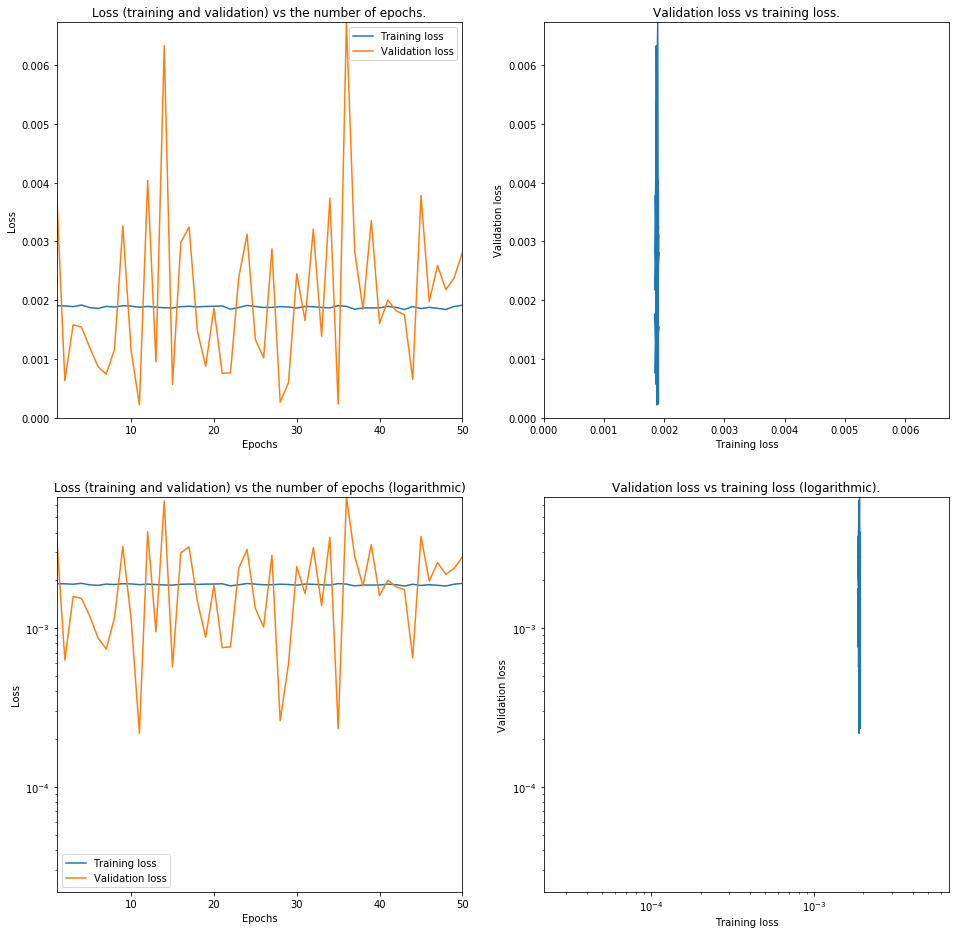

Optimizer: 0 learning rate: 1e-07


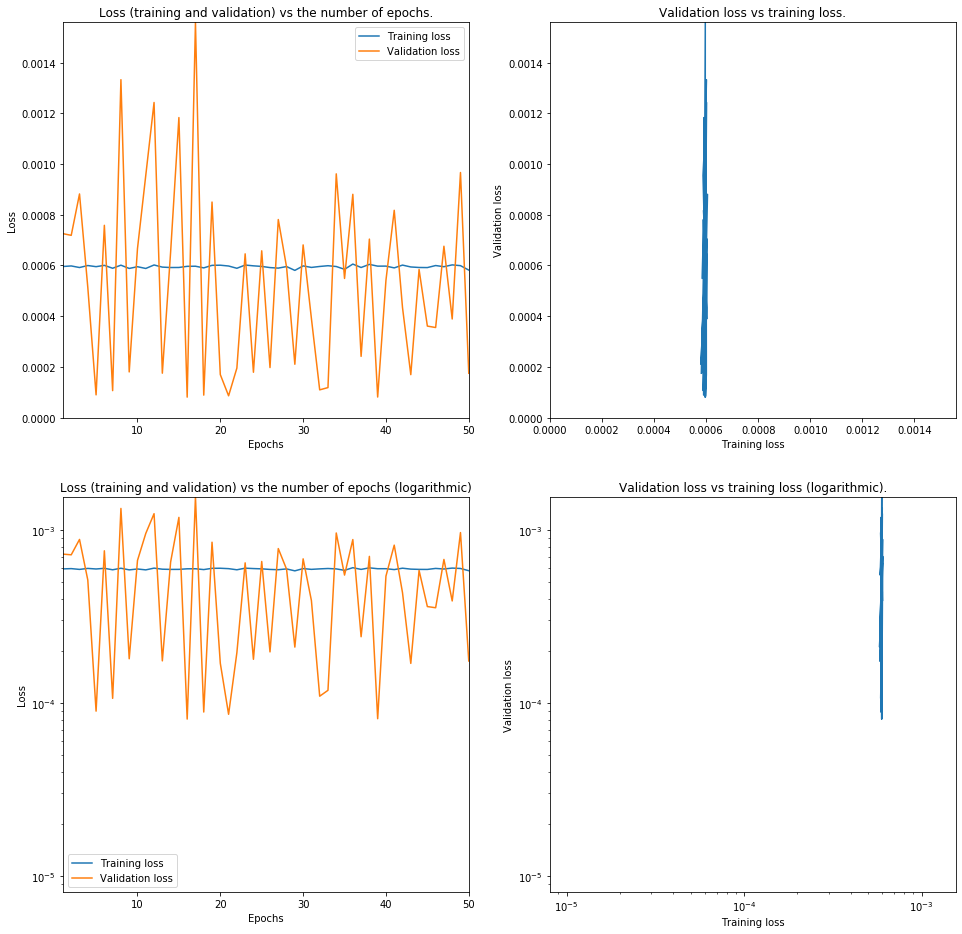

Optimizer: 0 learning rate: 3.162277660168379e-08


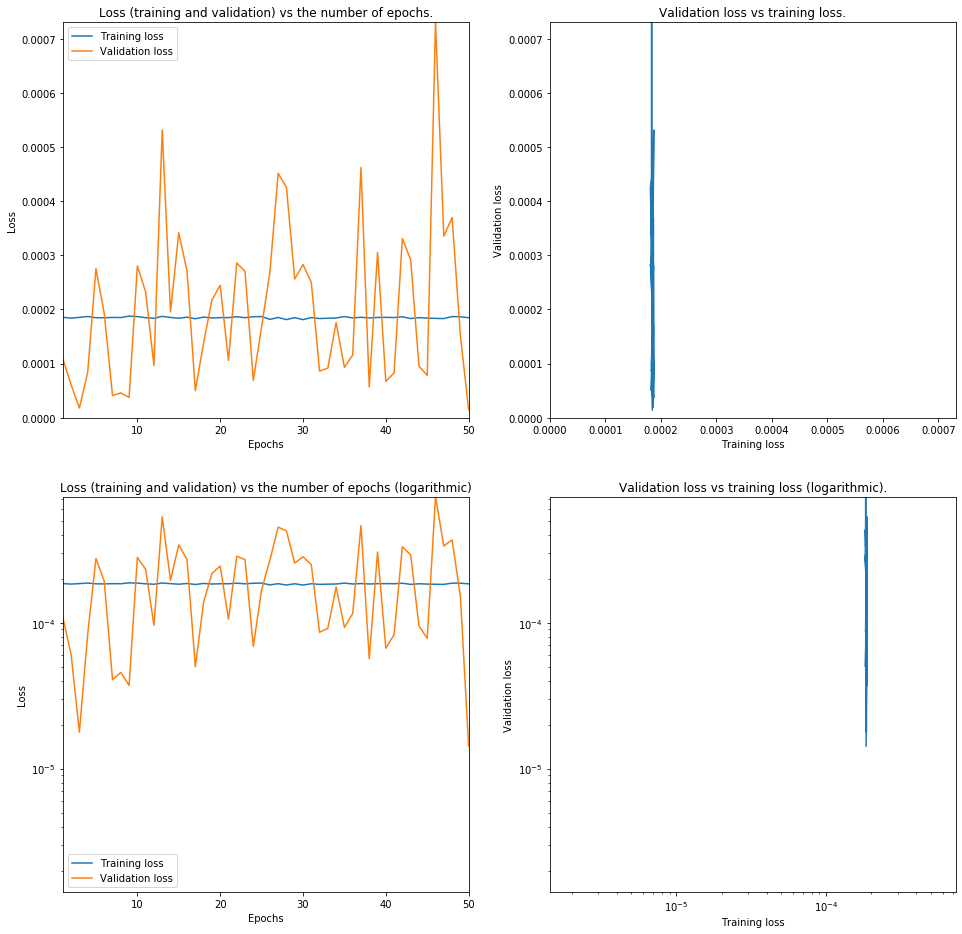

Optimizer: 0 learning rate: 1e-08


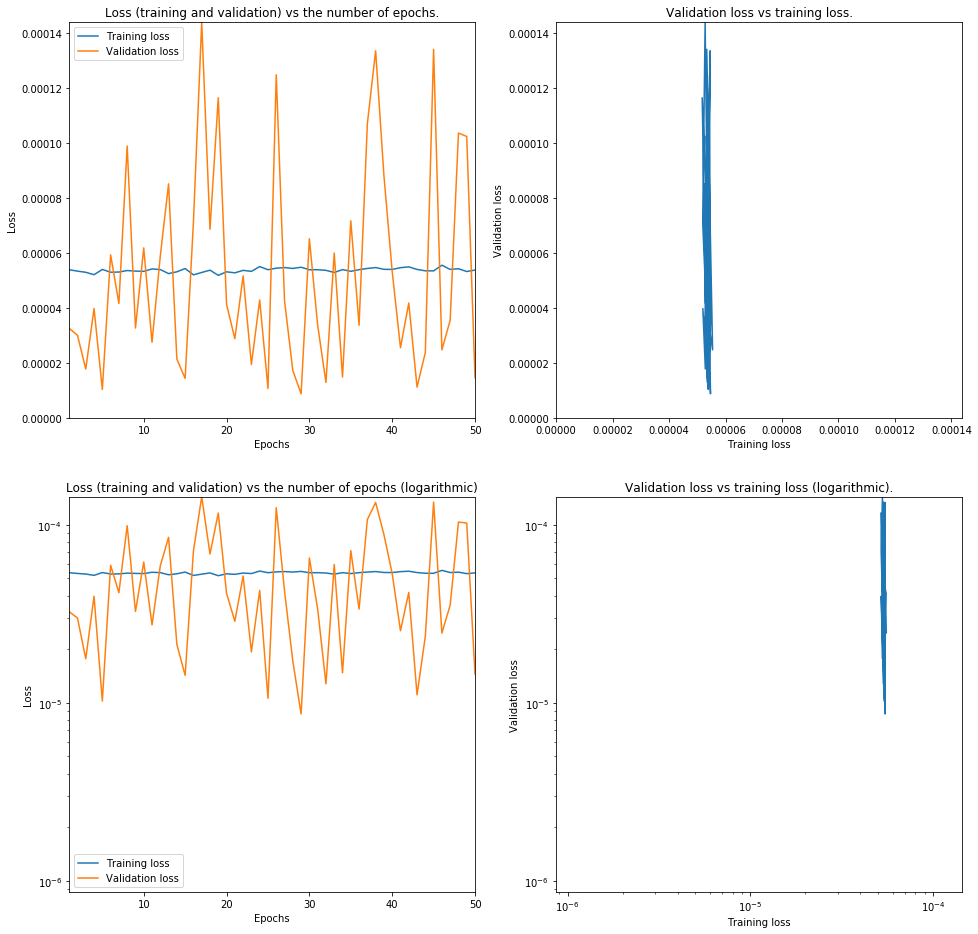

Optimizer: 1 learning rate: 0.0001


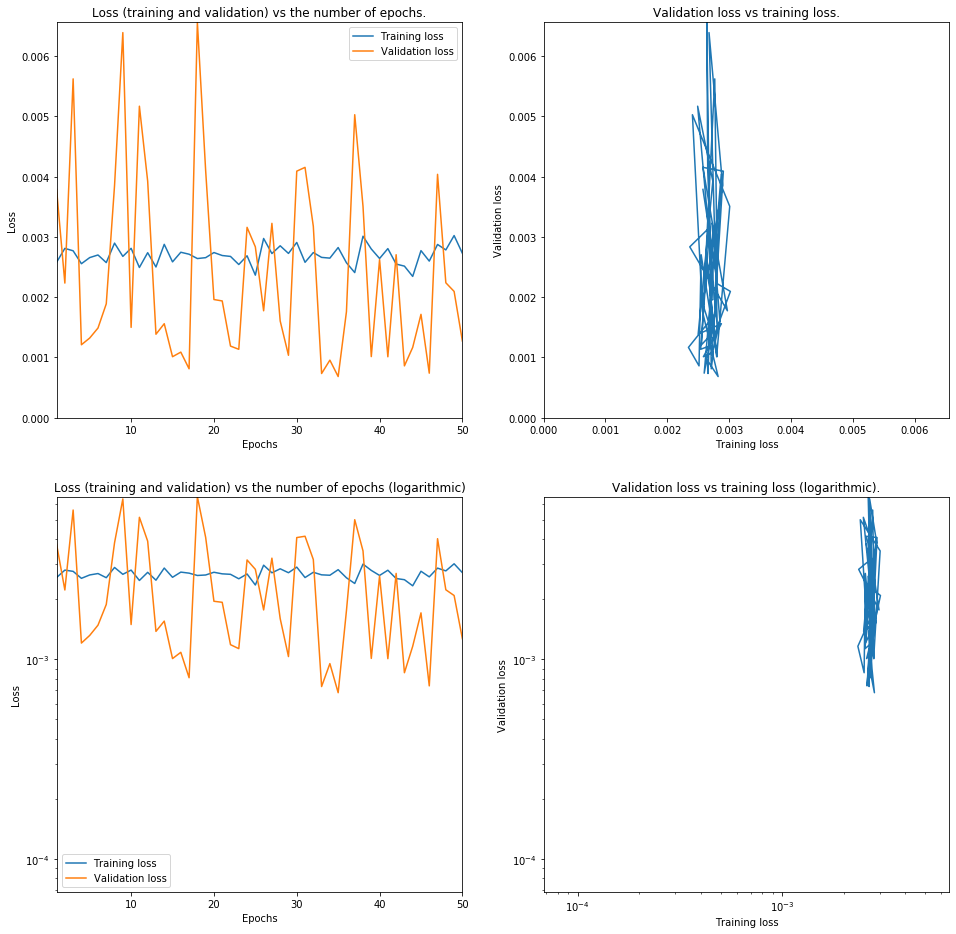

Optimizer: 1 learning rate: 3.1622776601683795e-05


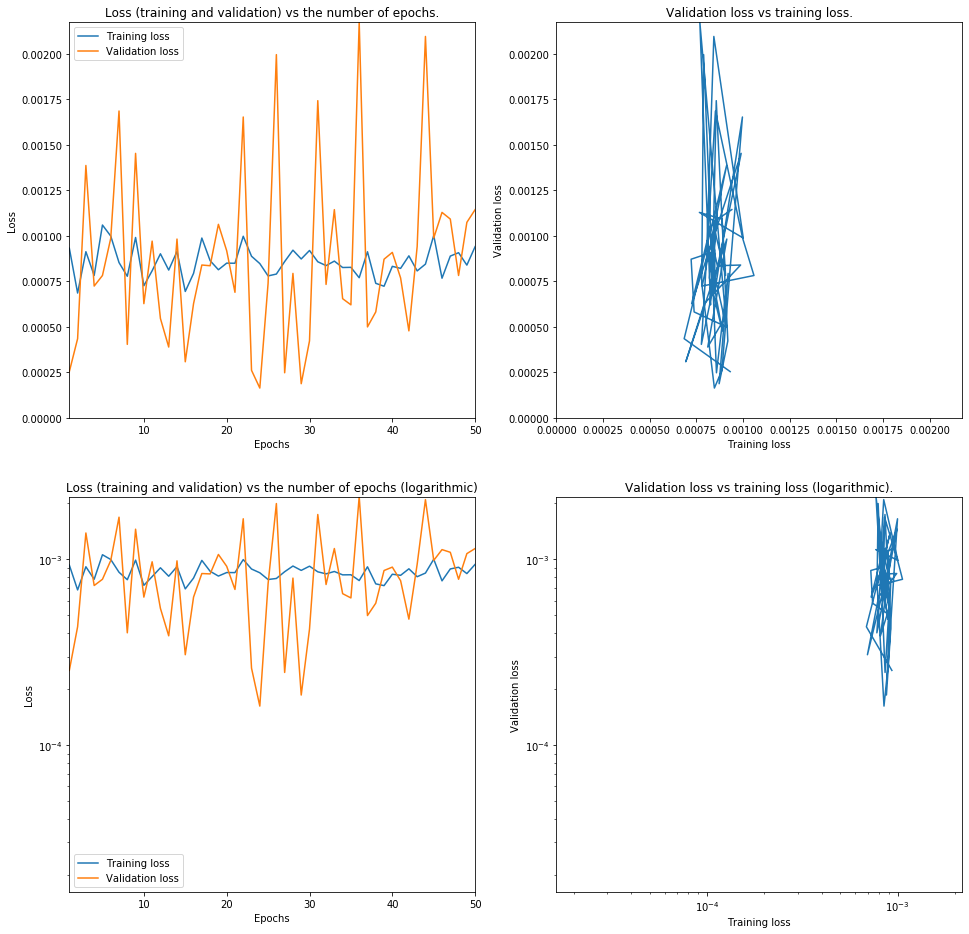

Optimizer: 1 learning rate: 1e-05


KeyboardInterrupt: 

In [29]:
settingsLineaerNet = [['Dense', 1, 'linear', False]]
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

optimizers = [SGD, adam, nadam, adagrad, rmsprop, adadelta]

for i in range(len(optimizers)):
    for j in np.logspace(-4, -8, 9):
        print('Optimizer:', i, 'learning rate:', j)
        model = makeDenseNetwork(inputSize, settingsLineaerNet, j, kernalInitializer='he_uniform', lossFunction=MAE, optimizer=optimizers[i])
        model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
        #model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])
        
        fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=50, verbose=0, callbacks=callbacksNetwork)
        history = plotHistory(fitDetails)

## Linear network real data

In [18]:
name = 'LinearNetwork'
settingsLineaerNet = [['Dense', 1, 'linear', False]]
learningRate = 1*10**-4
callbacksNetwork = [keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, optimizer=adam)
#model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
#model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])


model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
print(model.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
12990/12990 [==============================] - 1s 84us/step
217.04368244549968
51960/51960 [==============================] - 2s 34us/step
217.17629329455275
Layer 0:  [array([[ 0.12783986],
       [ 0.52723956],
       [ 0.46471286],
       [ 0.5663272 ],
       [-0.542946  ],
       [ 0.53836906],
       [ 0.12544996],
       [-0.48630252],
       [-0.61443657],
       [-0.2920637 ],
       [ 0.575686  ],
       [ 0.0525896 ],
       [ 0.00863576]], dtype=float32)]


Train on 36372 samples, validate on 15588 samples
Epoch 1/100
36372/36372 [==============================] - 3s 85us/step - loss: 204.6672 - val_loss: 189.9313
Epoch 2/100
36372/36372 [==============================] - 3s 76us/step - loss: 178.5530 - val_loss: 163.9625
Epoch 3/100
36372/36372 [==============================] - 3s 85us/step - loss: 152.4257 - val_loss: 138.0132
Epoch 4/100
36372/36372 [==============================] - 3s 95us/step - loss: 126.1734 - val_loss: 111.9183
Epoch 5/100
36372/36372 [==============================] - 4s 99us/step - loss: 99.9891 - val_loss: 86.0433
Epoch 6/100
36372/36372 [==============================] - 3s 90us/step - loss: 73.8659 - val_loss: 60.0888
Epoch 7/100
36372/36372 [==============================] - 3s 71us/step - loss: 47.6008 - val_loss: 33.9784
Epoch 8/100
36372/36372 [==============================] - 3s 80us/step - loss: 22.1086 - val_loss: 12.1397
Epoch 9/100
36372/36372 [==============================] - 3s 79us/step - loss

Epoch 77/100
36372/36372 [==============================] - 2s 62us/step - loss: 0.1175 - val_loss: 0.1134
Epoch 78/100
36372/36372 [==============================] - 2s 63us/step - loss: 0.1132 - val_loss: 0.1101
Epoch 79/100
36372/36372 [==============================] - 2s 62us/step - loss: 0.1084 - val_loss: 0.1044
Epoch 80/100
36372/36372 [==============================] - 2s 64us/step - loss: 0.1046 - val_loss: 0.1028
Epoch 81/100
36372/36372 [==============================] - 2s 63us/step - loss: 0.0998 - val_loss: 0.0963
Epoch 82/100
36372/36372 [==============================] - 2s 62us/step - loss: 0.0957 - val_loss: 0.0912
Epoch 83/100
36372/36372 [==============================] - 2s 62us/step - loss: 0.0915 - val_loss: 0.0890
Epoch 84/100
36372/36372 [==============================] - 2s 65us/step - loss: 0.0873 - val_loss: 0.0839
Epoch 85/100
36372/36372 [==============================] - 2s 68us/step - loss: 0.0829 - val_loss: 0.0796
Epoch 86/100
36372/36372 [===========

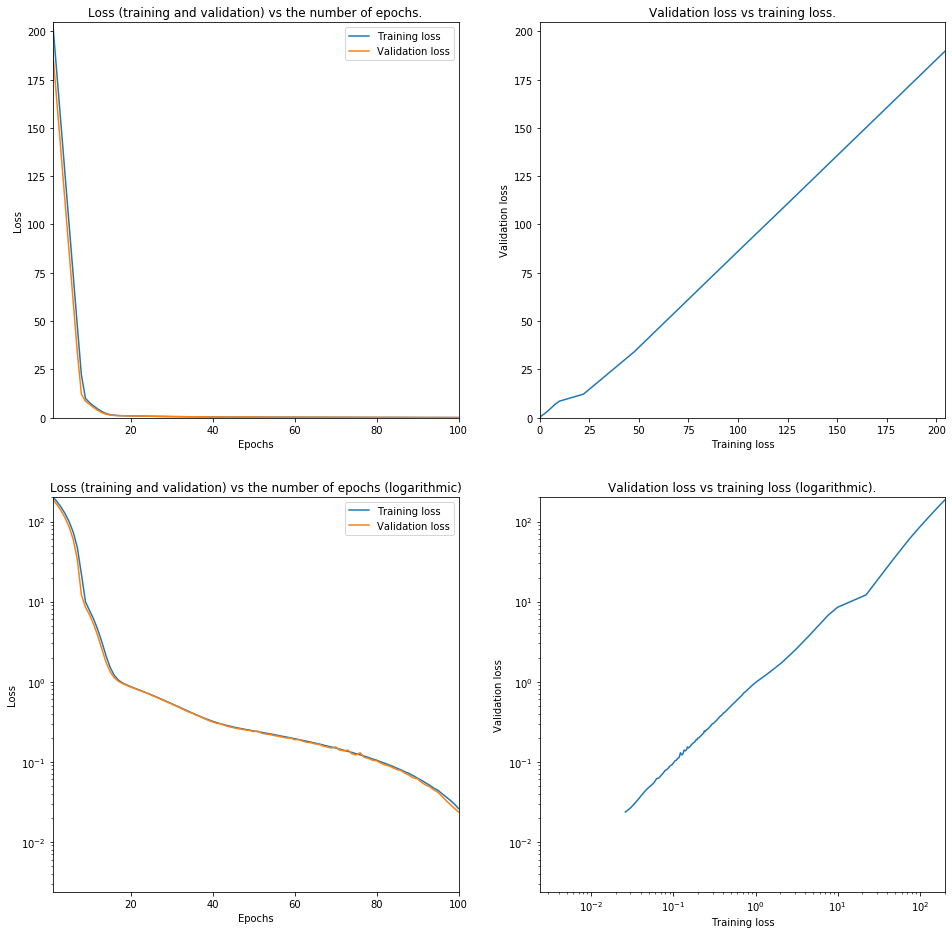

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1)                 13        
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
0.024320993576775248
Layer 0:  [array([[1.0005717 ],
       [0.98587424],
       [0.9998365 ],
       [1.0068444 ],
       [0.9534544 ],
       [1.0371627 ],
       [0.9980555 ],
       [1.004231  ],
       [0.99998313],
       [0.998927  ],
       [1.0063965 ],
       [0.99523365],
       [1.0002738 ]], dtype=float32)]


In [19]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=100, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

## Real data complex network

In [20]:
name = '1DenseLayerNetwork'
settingsLineaerNet = [['Dense', 128, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 1*10**-4
callbacksNetwork = []#[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, optimizer=adam)
#model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
#model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])


model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
print(model.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 128       
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
12990/12990 [==============================] - 0s 34us/step
258.6419996230762
51960/51960 [==============================] - 2s 29us/step
258.9324643576301
Layer 0:  [array([[ 0.15141124, -0.02658051, -0.2890168 , ..., -0.52530396,
        -0.63279724, -0.5669519 ],
       [ 0.13621134, -0.32277825, -0.14179713, ...,  0.3200649 ,
        -0.06060368, -0.00415593],
       [ 0.61648095,  0.6439309 ,  0.20134765, ..., -0.4061888 ,
        -0.54547715,  0.6277019 ],
       ...,
       [ 0.5148066 ,  0.30448478, -

Train on 36372 samples, validate on 15588 samples
Epoch 1/100
36372/36372 [==============================] - 3s 78us/step - loss: 84.1811 - val_loss: 7.1026
Epoch 2/100
36372/36372 [==============================] - 3s 77us/step - loss: 2.4334 - val_loss: 0.6251
Epoch 3/100
36372/36372 [==============================] - 3s 74us/step - loss: 0.4698 - val_loss: 0.3752
Epoch 4/100
36372/36372 [==============================] - 3s 69us/step - loss: 0.3539 - val_loss: 0.4597
Epoch 5/100
36372/36372 [==============================] - 3s 70us/step - loss: 0.3134 - val_loss: 0.2924
Epoch 6/100
36372/36372 [==============================] - 3s 71us/step - loss: 0.2788 - val_loss: 0.2405
Epoch 7/100
36372/36372 [==============================] - 3s 70us/step - loss: 0.2482 - val_loss: 0.2329
Epoch 8/100
36372/36372 [==============================] - 3s 73us/step - loss: 0.2430 - val_loss: 0.2646
Epoch 9/100
36372/36372 [==============================] - 3s 70us/step - loss: 0.2301 - val_loss: 0.

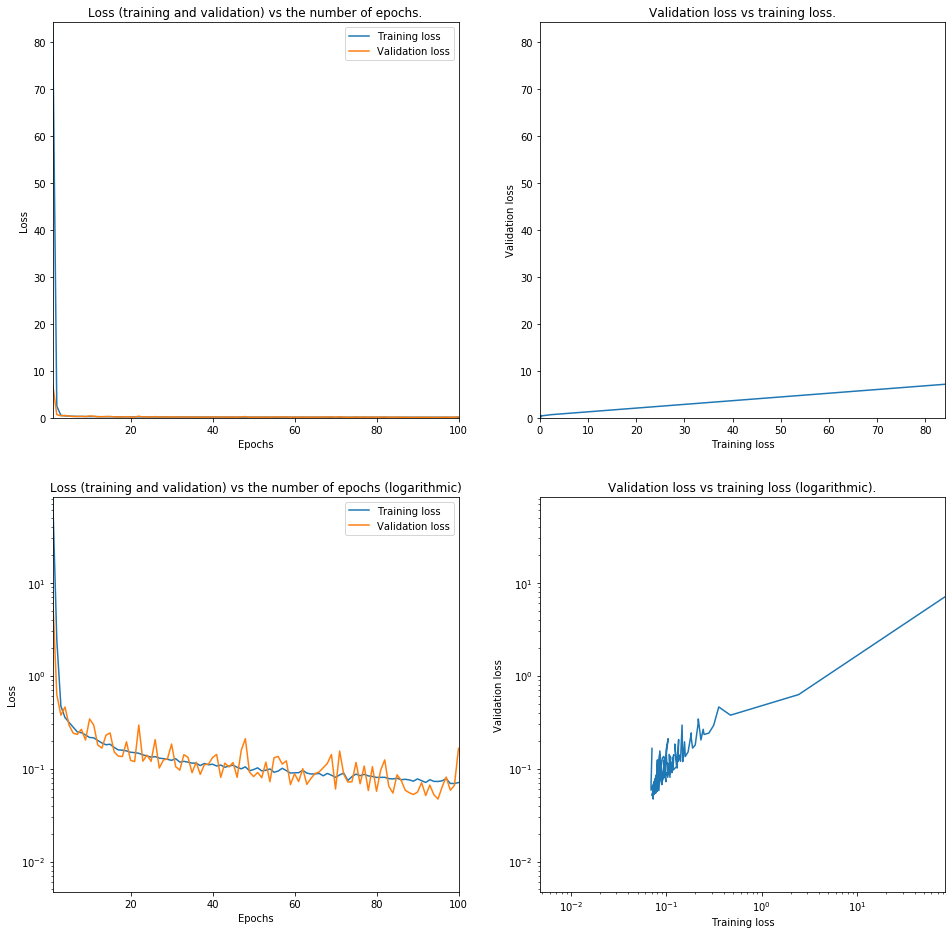

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 128       
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________
0.16583414132591393
Layer 0:  [array([[ 0.14808294, -0.04770265, -0.3948936 , ..., -0.37624842,
        -0.47552875, -0.39322233],
       [ 0.27281144, -0.40409166, -0.18183412, ...,  0.40069467,
        -0.04243942, -0.04848498],
       [ 0.4517228 ,  0.621748  ,  0.10093299, ..., -0.25432315,
        -0.28821385,  0.4755534 ],
       ...,
       [ 0.5643777 ,  0.23626077, -0.22466096, ..., -0.28136513,
         0.41257995,  0.11671039],
       [-0.14401   , -0.22643983,  0.48651007, ..., -0.30753207,
      

In [21]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=100, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

## Real very complex data

In [22]:
name = '2DenseLayerNetwork'
settingsLineaerNet = [['Dense', 128, 'softplus', False], ['Dense', 128, 'softplus', False], ['Dense', 1, 'linear', False]]
learningRate = 1*10**-4
callbacksNetwork = []#[keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=50, min_delta=2*10**-1)]

model = makeDenseNetwork(inputSize, settingsLineaerNet, learningRate, kernalInitializer='he_uniform', lossFunction=MAE, optimizer=adam)
#model.layers[0].set_weights([np.array([[1] for i in range(inputSize)])])
#model.layers[0].set_weights([np.array([[random.uniform(0.5, 1.5)] for i in range(inputSize)])])


model.summary()
print(model.evaluate(validationInput['input'], validationInput['target'], verbose=1))
print(model.evaluate(trainingInput['input'], trainingInput['target'], verbose=1))
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16384     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 128       
Total params: 18,176
Trainable params: 18,176
Non-trainable params: 0
_________________________________________________________________
12990/12990 [==============================] - 0s 35us/step
200.8791277221022
51960/51960 [==============================] - 2s 34us/step
200.91167226883886
Layer 0:  [array([[ 0.06721789,  0.35280883,  0.19343495, ..., -0.34653977,
        -0.27063656, -0.17401433],
       [-0.6656103 , -0.06659365,  0.06775516, ...,  0.2343378 ,
         0.15968418,  0.65194345],
       [-0.2

Train on 36372 samples, validate on 15588 samples
Epoch 1/200
36372/36372 [==============================] - 3s 85us/step - loss: 11.4143 - val_loss: 1.1682
Epoch 2/200
36372/36372 [==============================] - 3s 82us/step - loss: 0.8725 - val_loss: 1.1229
Epoch 3/200
36372/36372 [==============================] - 3s 83us/step - loss: 0.7159 - val_loss: 0.4930
Epoch 4/200
36372/36372 [==============================] - 3s 81us/step - loss: 0.6317 - val_loss: 1.1569
Epoch 5/200
36372/36372 [==============================] - 3s 77us/step - loss: 0.5582 - val_loss: 0.6088
Epoch 6/200
36372/36372 [==============================] - 3s 77us/step - loss: 0.5760 - val_loss: 0.3697
Epoch 7/200
36372/36372 [==============================] - 3s 88us/step - loss: 0.5826 - val_loss: 0.5953
Epoch 8/200
36372/36372 [==============================] - 3s 84us/step - loss: 0.4691 - val_loss: 0.3595
Epoch 9/200
36372/36372 [==============================] - 3s 88us/step - loss: 0.5020 - val_loss: 0.

36372/36372 [==============================] - 3s 84us/step - loss: 0.2929 - val_loss: 0.1422
Epoch 154/200
36372/36372 [==============================] - 3s 83us/step - loss: 0.2414 - val_loss: 0.2018
Epoch 155/200
36372/36372 [==============================] - 3s 83us/step - loss: 0.2498 - val_loss: 0.1747
Epoch 156/200
36372/36372 [==============================] - 3s 84us/step - loss: 0.2643 - val_loss: 0.2406
Epoch 157/200
36372/36372 [==============================] - 3s 85us/step - loss: 0.2669 - val_loss: 0.3529
Epoch 158/200
36372/36372 [==============================] - 3s 85us/step - loss: 0.2410 - val_loss: 0.2414
Epoch 159/200
36372/36372 [==============================] - 3s 84us/step - loss: 0.2165 - val_loss: 0.4132
Epoch 160/200
36372/36372 [==============================] - 3s 84us/step - loss: 0.2351 - val_loss: 0.1748
Epoch 161/200
36372/36372 [==============================] - 3s 85us/step - loss: 0.2676 - val_loss: 0.4326
Epoch 162/200
36372/36372 [===============

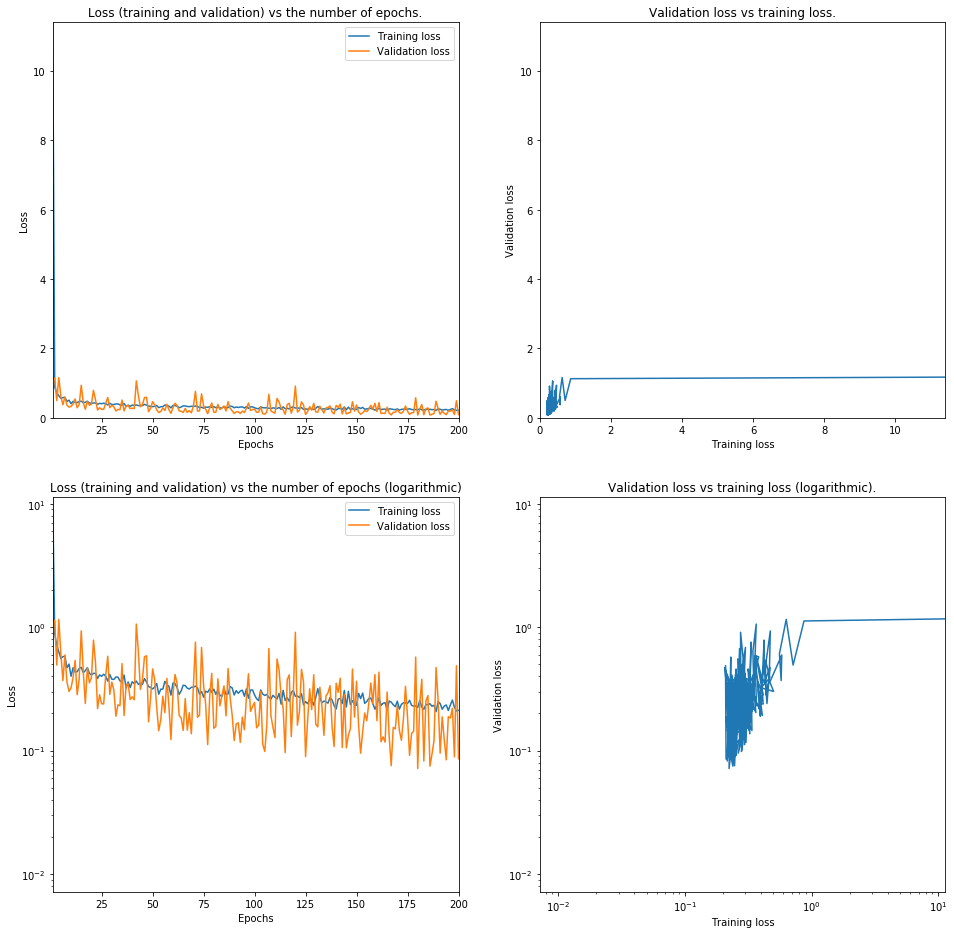

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 128)               1664      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16384     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 128       
Total params: 18,176
Trainable params: 18,176
Non-trainable params: 0
_________________________________________________________________
0.08598268073714634
Layer 0:  [array([[ 0.06902386,  0.26477754, -0.01145316, ..., -0.43704754,
        -0.26595783, -0.32292694],
       [-0.7710902 ,  0.00123242, -0.32531625, ...,  0.37149233,
         0.00143004,  0.57649225],
       [-0.34261456,  0.17947596,  0.42262295, ...,  0.43030703,
        -0.22231549, -0.05088912],
       ...,
       [-0.2582525 , -0.40784526,  0.

In [23]:
fitDetails = model.fit(trainingInput['input'], trainingInput['target'], validation_split=0.3, epochs=200, verbose=1, callbacks=callbacksNetwork)

history = plotHistory(fitDetails)

evaluation = model.evaluate(validationInput['input'], validationInput['target'], verbose=0)
models.append({'model':model, 'name':str(prefixName) + name, 'evaluation':evaluation, 'history':history})
prefixName = prefixName + 1

model.summary()
print(evaluation)
for i in range(len(model.layers)):
    print('Layer ' + str(i) + ': ', model.layers[i].get_weights())

# TEMP

In [ ]:
print(np.shape(trainingInput['input']))
print(np.shape(trainingInput['target']))

In [ ]:
dataset = np.loadtxt('pima-indians-diabetes.csv', delimiter=',')
#print(dataset)
# split into input (X) and output (y) variables
X = dataset[:,0:8]
y = dataset[:,8]

print(np.shape(X))
print(np.shape(y))
print(X)
print(y)

model = Sequential()
model.add(Dense(12, input_dim=8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, y, epochs=150, batch_size=10)